In [2]:
import numpy as np

from keplergl import KeplerGl

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [3]:
#read_file = pd.read_csv(r'significant-earthquake-database.csv')
df=pd.read_table("earthquakes-2023.tsv",sep='\t')
#csv_table.to_csv('earthquakes-2023.csv',index=False)
#df = pd.read_csv('earthquakes-2023.csv')
display(df)

,Search Parameters,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Location Name,...,Total Missing,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description
0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-2150.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,"JORDAN: BAB-A-DARAA,AL-KARAK",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,-2000.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,SYRIA: UGARIT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,-2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TURKMENISTAN: W,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
4,NaN,-1610.0,NaN,NaN,NaN,NaN,NaN,3.0,1351.0,GREECE: THERA ISLAND (SANTORINI),...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6347,NaN,2023.0,2.0,6.0,1.0,17.0,35.0,5873.0,NaN,TURKEY; SYRIA,...,NaN,NaN,118300.0,4.0,34200.0,4.0,174321.0,4.0,NaN,4.0
6348,NaN,2023.0,2.0,6.0,10.0,24.0,49.0,NaN,NaN,TURKEY; SYRIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6349,NaN,2023.0,2.0,9.0,6.0,28.0,0.0,NaN,NaN,INDONESIA: NEW GUINEA: IRIAN JAYA: JAYAPURA,...,NaN,NaN,NaN,NaN,NaN,1.0,15.0,1.0,28.0,1.0
6350,NaN,2023.0,2.0,20.0,17.0,4.0,29.0,NaN,NaN,TURKEY; SYRIA,...,NaN,NaN,200.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Geospacial plots

# create a new dataframe with 'Latitude', 'Longitude', 'Mag', 'Location Name'
df_seismic = df[['Latitude', 'Longitude', 'Mag', 'Location Name']]
# remove all columns with NaN values
df_seismic = df_seismic.dropna()
display(df_seismic)

,Latitude,Longitude,Mag,Location Name
1,31.100,35.500,7.3,"JORDAN: BAB-A-DARAA,AL-KARAK"
3,38.000,58.200,7.1,TURKMENISTAN: W
8,32.000,35.500,6.5,ISRAEL: ARIHA (JERICHO)
9,29.600,35.000,6.2,JORDAN: SW: TIMNA COPPER MINES
15,39.700,23.300,7.0,GREECE: MACEDONIA
...,...,...,...,...
6347,37.166,37.042,7.8,TURKEY; SYRIA
6348,38.024,37.203,7.5,TURKEY; SYRIA
6349,-2.635,140.557,5.1,INDONESIA: NEW GUINEA: IRIAN JAYA: JAYAPURA
6350,36.109,36.017,6.3,TURKEY; SYRIA


In [5]:
map = KeplerGl(height=600)
map.add_data(data=df_seismic, name='seismic')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [6]:
map.save_to_html(file_name='seismic.html')

Map saved to seismic.html!


In [91]:
print(df.columns)
# display(df['Deaths'])

Index(['Search Parameters', 'Year', 'Mo', 'Dy', 'Hr', 'Mn', 'Sec', 'Tsu',
       'Vol', 'Location Name', 'Latitude', 'Longitude', 'Focal Depth (km)',
       'Mag', 'MMI Int', 'Deaths', 'Death Description', 'Missing',
       'Missing Description', 'Injuries', 'Injuries Description',
       'Damage ($Mil)', 'Damage Description', 'Houses Destroyed',
       'Houses Destroyed Description', 'Houses Damaged',
       'Houses Damaged Description', 'Total Deaths', 'Total Death Description',
       'Total Missing', 'Total Missing Description', 'Total Injuries',
       'Total Injuries Description', 'Total Damage ($Mil)',
       'Total Damage Description', 'Total Houses Destroyed',
       'Total Houses Destroyed Description', 'Total Houses Damaged',
       'Total Houses Damaged Description', 'Country'],
      dtype='object')


0           NaN
1           NaN
2           NaN
3           1.0
4           NaN
         ...   
6347    51003.0
6348        NaN
6349        4.0
6350        6.0
6351        2.0
Name: Deaths, Length: 6352, dtype: float64

In [8]:
# Correlation checks

# check all column correlations and save the one with highest correlation
cor = df.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()
# show all entries with correlation > 0.5
cor[cor > 0.5].head(60)
#Total Houses Damaged                Injuries 0.980400 correlation

Year                                Year                                  1.000000
Total Missing                       Missing                               0.999999
Houses Destroyed                    Total Houses Destroyed                0.998884
Missing                             Total Deaths                          0.997842
                                    Deaths                                0.997840
Total Deaths                        Total Missing                         0.997336
Total Missing                       Deaths                                0.996844
Houses Damaged                      Houses Destroyed                      0.996509
Total Houses Destroyed              Houses Damaged                        0.996338
Total Houses Damaged                Total Houses Destroyed                0.996114
                                    Houses Destroyed                      0.996062
Injuries Description                Total Injuries Description            0.995341
Hous

,Country,Mag
1,JORDAN,7.3
3,TURKMENISTAN,7.1
8,ISRAEL,6.5
9,JORDAN,6.2
15,GREECE,7.0
...,...,...
6347,TURKEY,7.8
6348,TURKEY,7.5
6349,INDONESIA,5.1
6350,TURKEY,6.3


266
CHINA    586
Name: Country, dtype: int64


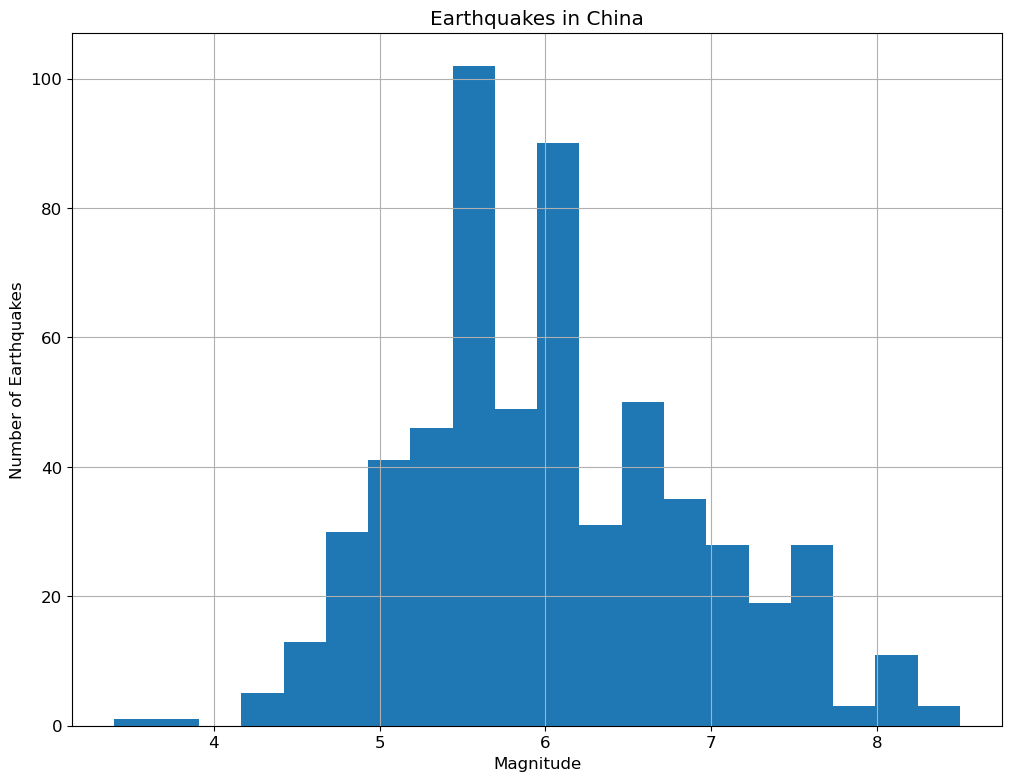

In [9]:
# Histograms of magnitude

# make a new column called 'Country' taking the part of the string in 'Location Name'
# before the first colon or before the first semi-colon
df['Country'] = df['Location Name'].str.split(':|;', expand=True)[0]
# make a new dataframe with 'Country' and 'Mag'
df_country = df[['Country', 'Mag']]
# remove all columns with NaN values
df_country = df_country.dropna()
display(df_country)
# find how many countries are in the dataframe
print(df_country['Country'].nunique())
# find which country appears the most and the number of times it happens
print(df_country['Country'].value_counts().head(1))
# make a new data frame for the country with the most earthquakes
df_country_most = df_country[df_country['Country'] == 'CHINA']
# make a histogram having 'Mag' on the x-axis and the number of earthquakes on the y-axis
df_country_most['Mag'].hist(bins=20)
plt.xlabel('Magnitude')
plt.ylabel('Number of Earthquakes')
plt.title('Earthquakes in China')
plt.show()

In [10]:
## Average MAG by Country
# get average 'Mag' for each country by joining rows of same country name
df_country_mean = df_country.groupby('Country').mean()
# sort the dataframe by 'Mag' in descending order
df_country_mean = df_country_mean.sort_values(by='Mag', ascending=False)
display(df_country_mean)

,Mag
Country,
CASCADIA SUBDUCTION ZONE,9.000000
INDIA-CHINA,8.250000
BOLIVIA-PERU,8.200000
MACQUARIE ISLAND,8.200000
BALLENY ISLANDS,8.100000
...,...
CZECH REPUBLIC,4.100000
THE NETHERLANDS,3.933333
POLAND,3.800000


In [11]:
# # deaths and damage

# # new dataframe with 'Year', 'Deaths', 'Damage ($Mil)'
# df_deaths_damage = df[['Country', 'Year', 'Deaths', 'Damage ($Mil)']]
# # find top most appearing countries in the dataframe
# print(df_deaths_damage['Country'].value_counts().head(10))
# # for each country make one bar graph with year on x-axis and deaths on y-axis left side damage on y-axis right side
# for country in df_deaths_damage['Country'].value_counts().head(10).index:
#     df_country = df_deaths_damage[df_deaths_damage['Country'] == country]
#     df_country = df_country.dropna()
#     df_country.plot(x='Year', y=['Deaths', 'Damage ($Mil)'], kind='bar', secondary_y='Damage ($Mil)')
#     plt.title(country)
#     plt.show()
# # # new dataframe that only include Country = 'JAPAN'
# # df_japan = df_year[df_year['Country'] == 'JAPAN']
# # # remove all columns with NaN values
# # df_japan = df_japan.dropna()
# # display(df_japan)
# # # make one bar graph with year on x-axis and deaths on y-axis left side damage on y-axis right side
# # df_japan.plot(x='Year', y=['Deaths', 'Damage ($Mil)'], kind='bar', secondary_y='Damage ($Mil)')
# # plt.show()

In [13]:
# # make a plot of earthquake amount by country
# df_deaths_damage['Country'].value_counts().head(10).plot(kind='bar')
# plt.xlabel('Country')
# plt.ylabel('Number of Earthquakes')
# plt.title('Earthquakes by Country')
# plt.show()

C:\Users\SiBuX\AppData\Local\Temp\ipykernel_5348\2681097054.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['Continent'] = df_country['Country'].map(df_continent.set_index('Country')['Continent'])


Text(0.5, 0.98, 'Earthquake Magnitude by Continent')

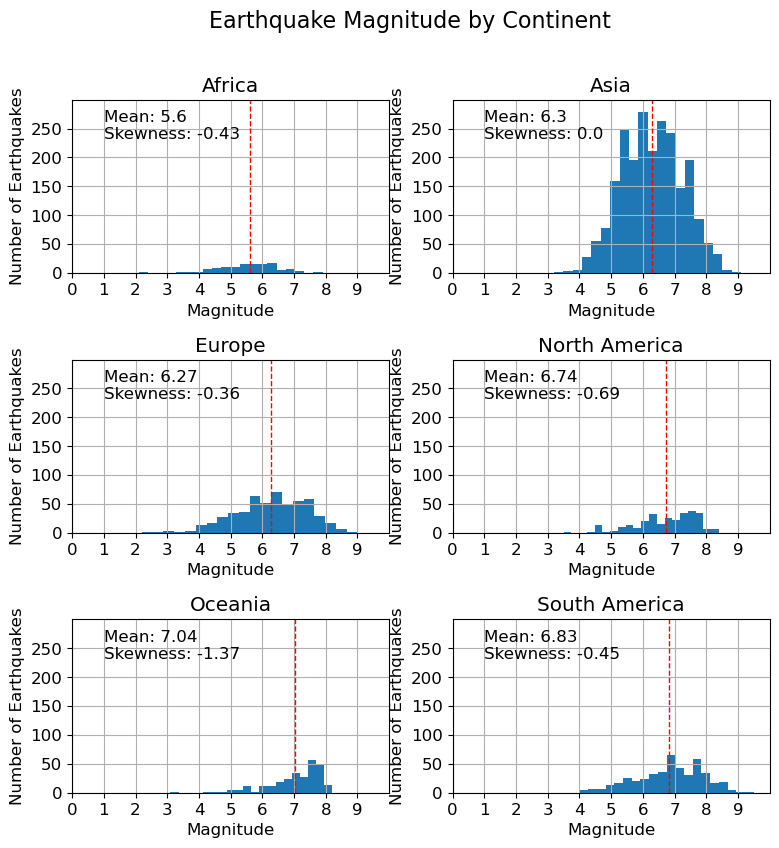

In [14]:
df['Country'] = df['Location Name'].str.split(':|;', expand=True)[0]
df_country = df[['Country', 'Mag']]
df_continent = pd.read_excel('continents.xlsx')
df_continent['Country'] = df_continent['Country'].str.upper()
df_country['Continent'] = df_country['Country'].map(df_continent.set_index('Country')['Continent'])
df_country = df_country.dropna()
df_continents = [df_country[df_country['Continent'] == 'Africa'],
                    df_country[df_country['Continent'] == 'Asia'],
                    df_country[df_country['Continent'] == 'Europe'],
                    df_country[df_country['Continent'] == 'North America'],
                    df_country[df_country['Continent'] == 'Oceania'],
                    df_country[df_country['Continent'] == 'South America']]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))
for i, ax in enumerate(axes.flatten()):
    df_continents[i]['Mag'].hist(bins=20, ax=ax)
    ax.set_title(df_continents[i]['Continent'].unique()[0])
    ax.set_xlim(0, 10)
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_ylim(0, 300)
    ax.set_yticks(np.arange(0, 300, 50))
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Number of Earthquakes')
    fig.subplots_adjust(hspace=0.5)
    ax.text(0.1, 0.9, 'Mean: ' + str(round(df_continents[i]['Mag'].mean(), 2)),
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.axvline(df_continents[i]['Mag'].mean(), color='r', linestyle='dashed', linewidth=1)
    ax.text(0.1, 0.8, 'Skewness: ' + str(round(df_continents[i]['Mag'].skew(), 2)),
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
fig.suptitle('Earthquake Magnitude by Continent', fontsize=16)
#fig.savefig('earthquake_magnitude_by_continent.png')

,Country,Mag,Year,Density
4,JORDAN,5.3,2004,62.697450
14,TURKMENISTAN,4.6,1983,6.558853
15,TURKMENISTAN,7.0,2000,9.723006
209,GREECE,6.3,1965,66.333072
210,GREECE,7.1,1965,66.333072
...,...,...,...,...
4375,MOZAMBIQUE,5.6,2017,36.330325
4376,MOZAMBIQUE,5.6,2018,37.416870
4377,MADAGASCAR,5.5,2017,44.980306
4378,ZAMBIA,5.9,2017,23.269151


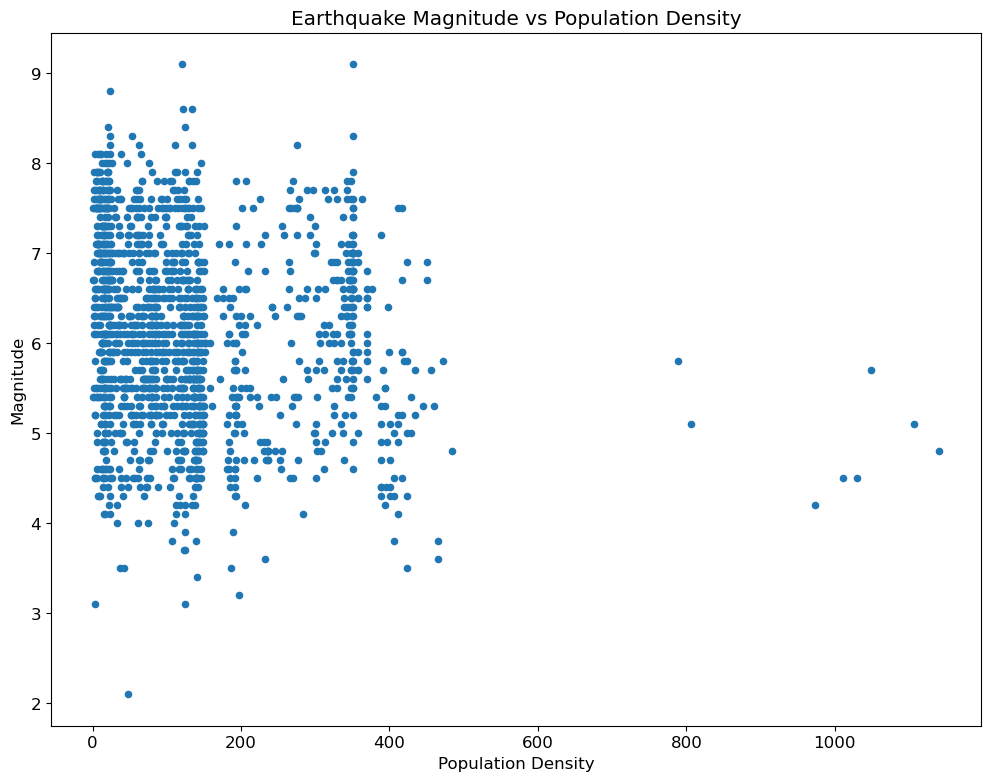

Text(0.5, 0.98, 'Earthquake Magnitude vs Population Density by Continent')

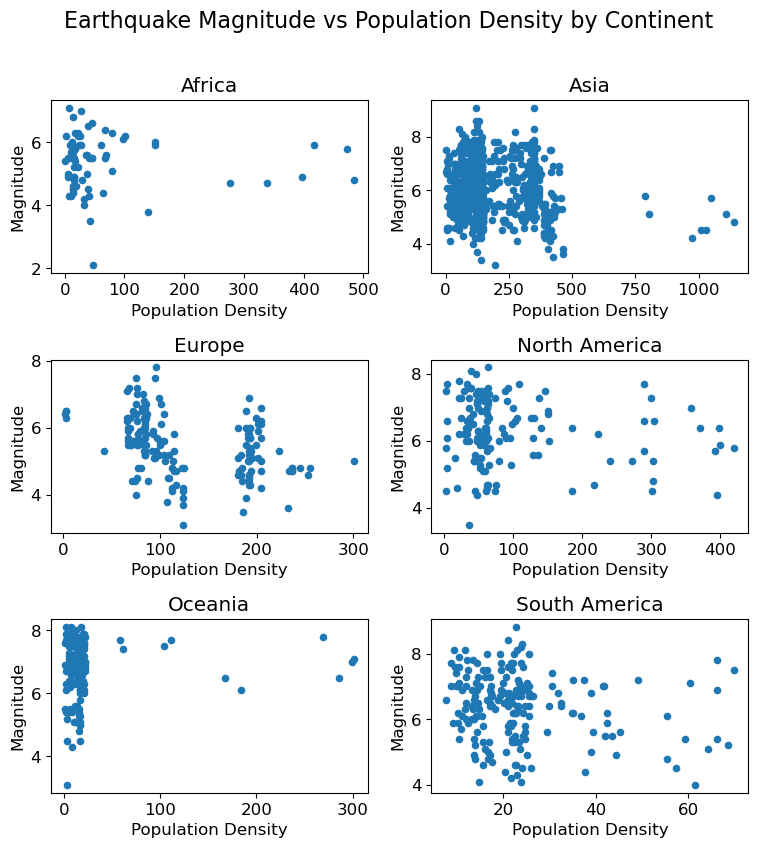

In [17]:
# Get population density of a country where an earthquake happened the same year

# load API_EN.POP.DNST_DS2_en_excel_v2_5113872 from https://data.worldbank.org/indicator/EN.POP.DNST?end=2020&start=2020&view=map
df_pop_den = pd.read_excel('API_EN.POP.DNST_DS2_en_excel_v2_5113872.xls', skiprows=3)
df['Country'] = df['Location Name'].str.split(':|;', expand=True)[0]
df_country = df[['Country', 'Mag', 'Year']]
# make country name capital letters
df_pop_den['Country Name'] = df_pop_den['Country Name'].str.upper()
df_pop_den = df_pop_den.drop(columns=['Indicator Code'])
df_pop_den = df_pop_den.drop(columns=['Indicator Name'])
df_pop_den = df_pop_den.drop(columns=['Country Code'])

# add all columns from df_pop_den to df_country based on country name
df_country_2 = df_country.merge(df_pop_den, left_on='Country', right_on='Country Name')

df_country_2 = df_country_2.drop(columns=['Country Name'])

# convert Year entries to string and remove .0
df_country_2['Year'] = df_country_2['Year'].astype(str).str[:-2]
#display(df_country_2)

# if a row entry in the 'Year' column is not in the name of a column in df_pop_den, drop that row
df_country_2 = df_country_2[df_country_2['Year'].isin(df_pop_den.columns)]
#display(df_country_2)

#make new dataframe with columns starting from 1960
df_country_3 = df_country_2[df_country_2.columns[3:]]

# if the 'Year' is equal to a column of df_country_3 make a new column called 'Density' and set it to the value of the intersection of the 'Year' and the column
for index, row in df_country_2.iterrows():
    for column in df_country_3.columns[3:]:
        if row['Year'] == column:
            df_country_2.loc[index, 'Density'] = row[column]

# drop all columns that are not 'Country', 'Mag', 'Year', or 'Density'
df_country_2 = df_country_2.drop(columns=df_country_2.columns[3:-1])
# drop all nan values
df_country_2 = df_country_2.dropna()
display(df_country_2)

# make a scatter plot of earthquake magnitude vs population density
df_country_2.plot(x='Density', y='Mag', kind='scatter')
plt.xlabel('Population Density')
plt.ylabel('Magnitude')
plt.title('Earthquake Magnitude vs Population Density')
plt.show()

# make a plot of earthquake magnitude vs population density by continent
df_country_2['Continent'] = df_country_2['Country'].map(df_continent.set_index('Country')['Continent'])
df_country_2 = df_country_2.dropna()
df_continents = [df_country_2[df_country_2['Continent'] == 'Africa'],
                    df_country_2[df_country_2['Continent'] == 'Asia'],
                    df_country_2[df_country_2['Continent'] == 'Europe'],
                    df_country_2[df_country_2['Continent'] == 'North America'],
                    df_country_2[df_country_2['Continent'] == 'Oceania'],
                    df_country_2[df_country_2['Continent'] == 'South America']]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))
for i, ax in enumerate(axes.flatten()):
    df_continents[i].plot(x='Density', y='Mag', kind='scatter', ax=ax)
    ax.set_title(df_continents[i]['Continent'].unique()[0])
    ax.set_xlabel('Population Density')
    ax.set_ylabel('Magnitude')
    fig.subplots_adjust(hspace=0.5)
fig.suptitle('Earthquake Magnitude vs Population Density by Continent', fontsize=16)


,Country,Mag,Year,Deaths,Density
15,TURKMENISTAN,7.0,2000,11.0,9.723006
207,GREECE,6.8,1962,1.0,65.540985
209,GREECE,6.3,1965,38.0,66.333072
210,GREECE,7.1,1965,6.0,66.333072
211,GREECE,6.2,1965,32.0,66.333072
...,...,...,...,...,...
4370,POLAND,3.7,2019,1.0,124.025595
4371,POLAND,3.9,2019,1.0,124.025595
4372,POLAND,3.1,2019,3.0,124.025595
4374,MOZAMBIQUE,7.0,2006,4.0,26.368908


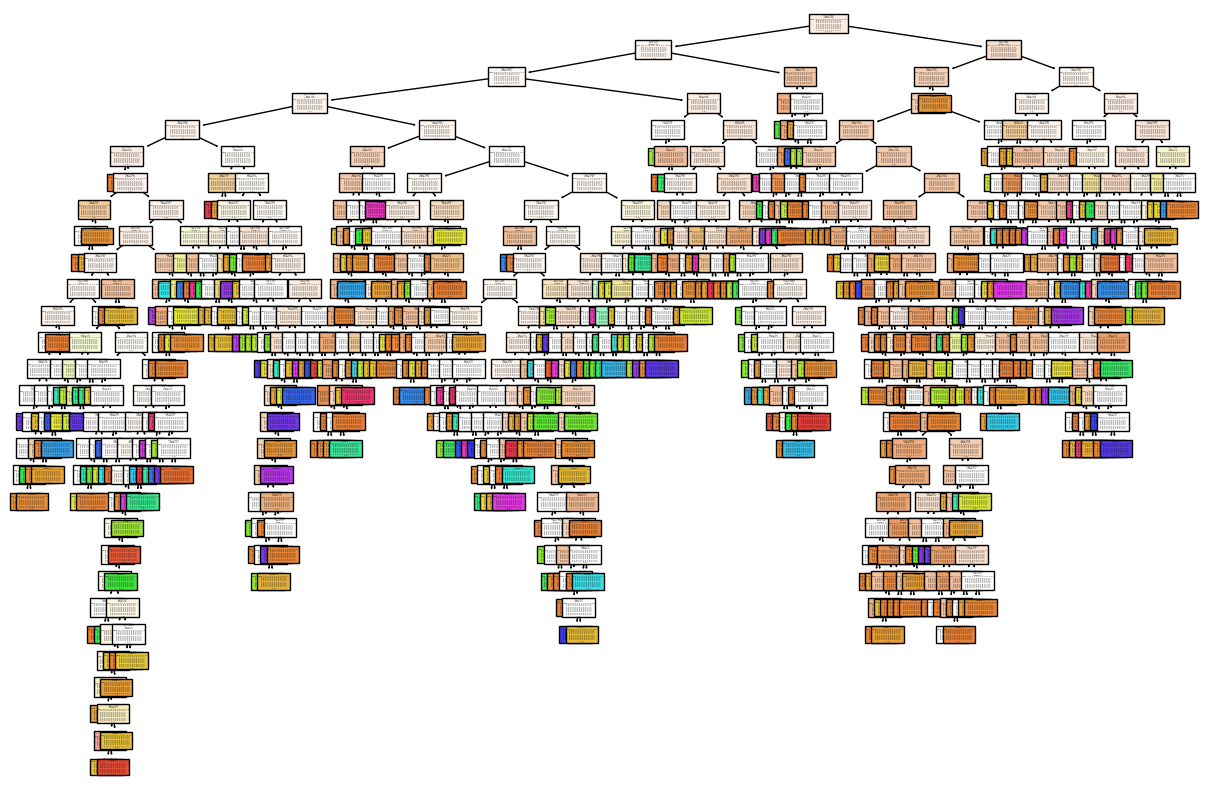

Accuracy:  0.05333333333333334
Predicted Deaths :  10.0


In [124]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree


def classifiy_earthquakes(feature_to_predict):
    df_pop_den = pd.read_excel('API_EN.POP.DNST_DS2_en_excel_v2_5113872.xls', skiprows=3)
    df['Country'] = df['Location Name'].str.split(':|;', expand=True)[0]
    df_country = df[['Country', 'Mag', 'Year', feature_to_predict]]
    # make country name capital letters
    df_pop_den['Country Name'] = df_pop_den['Country Name'].str.upper()
    df_pop_den = df_pop_den.drop(columns=['Indicator Code'])
    df_pop_den = df_pop_den.drop(columns=['Indicator Name'])
    df_pop_den = df_pop_den.drop(columns=['Country Code'])
    # add all columns from df_pop_den to df_country based on country name
    df_country_2 = df_country.merge(df_pop_den, left_on='Country', right_on='Country Name')
    df_country_2 = df_country_2.drop(columns=['Country Name'])
    # convert Year entries to string and remove .0
    df_country_2['Year'] = df_country_2['Year'].astype(str).str[:-2]
    # if a row entry in the 'Year' column is not in the name of a column in df_pop_den, drop that row
    df_country_2 = df_country_2[df_country_2['Year'].isin(df_pop_den.columns)]

    #make new dataframe with columns starting from 1960
    df_country_3 = df_country_2[df_country_2.columns[3:]]

    # if the 'Year' is equal to a column of df_country_3 make a new column called 'Density' and set it to the value of the intersection of the 'Year' and the column
    for index, row in df_country_2.iterrows():
        for column in df_country_3.columns[3:]:
            if row['Year'] == column:
                df_country_2.loc[index, 'Density'] = row[column]

    # drop all columns that are not 'Country', 'Mag', 'Year', or 'Density' or x
    df_country_2 = df_country_2.drop(columns=df_country_2.columns[4:-1])
    df_country_2 = df_country_2.dropna()
    display(df_country_2)

    data = df_country_2

    X = data.drop(feature_to_predict, axis=1)
    y = data[feature_to_predict]

    X = pd.get_dummies(X, columns=['Country'], prefix='c')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = DecisionTreeClassifier()

    #plot the decision tree
    clf = clf.fit(X_train, y_train)
    plt.figure(figsize=(15, 10))
    tree.plot_tree(clf, filled=True)
    plt.show()

    y_pred = clf.predict(X_test)

    def selected_country(country):
        cl = X.iloc[:1, X.columns.str.startswith('c_')].copy()
        cl = cl.reset_index(drop=True)
        cl = cl.replace(1, 0)
        country = 'c_' + country
        cl[country] = 1
        return cl

    # print accuracy
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    # print(clf.predict(X_test))

    # test the model and include Mag, Year, Density and features
    test = pd.DataFrame({'Mag': [6.5], 'Year': [2023], 'Density': [100]})
    test = pd.concat([test, selected_country('CHINA')], axis=1)
    print("Predicted", feature_to_predict,": ", clf.predict(test)[0])

classifiy_earthquakes(feature_to_predict='Deaths')

# # make confusion_matrix dataframe and print it
# print(confusion_matrix(y_test, y_pred))


c:\Users\SiBuX\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=24.
  warnings.warn(


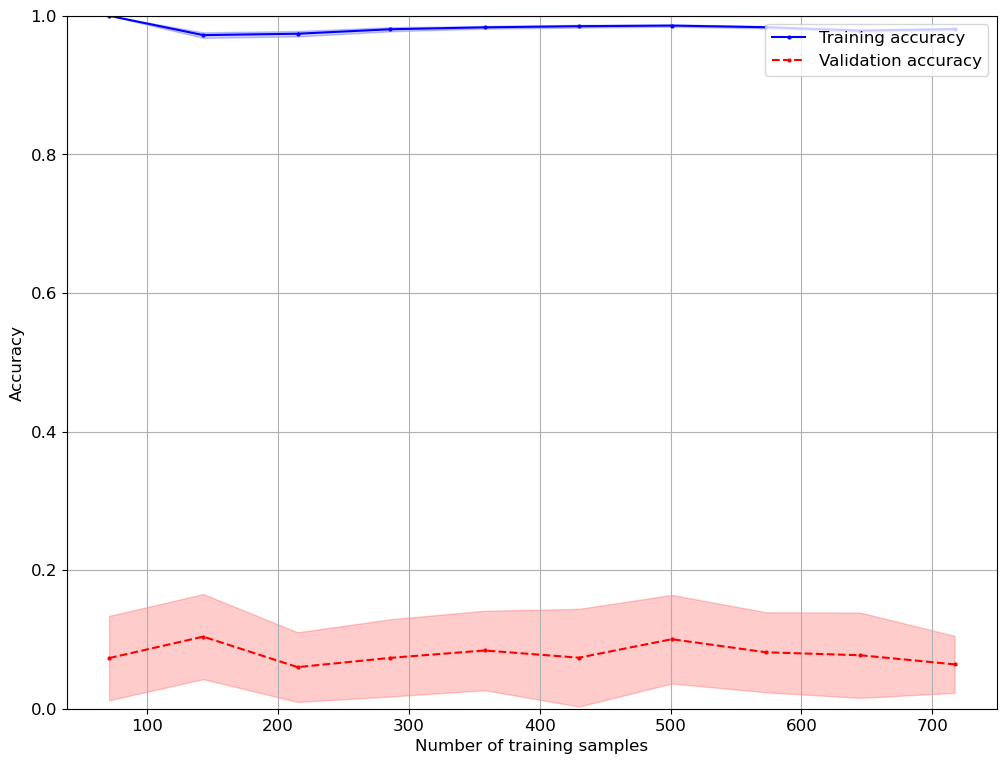

In [125]:
from sklearn.model_selection import learning_curve
# Use the learning_curve function to generate training and validation scores
train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=np.int_(796/32), n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=2, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_mean, color='red', linestyle='--', marker='o', markersize=2, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.2, color='red')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.ylim([0.0, 1.0])
plt.show()

# # find optimal number of features
# from sklearn.feature_selection import RFECV
# from sklearn.model_selection import StratifiedKFold

# # Create the RFE object and compute a cross-validated score.
# rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(10), scoring='accuracy')
# rfecv.fit(X, y)

# print("Optimal number of features : %d" % rfecv.n_features_)
# print('Best features: %s' % list(X.columns[rfecv.support_]))

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# # make key
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, label='Accuracy')
# plt.legend(loc="best")
# plt.show()


Ethical Considerations

Provide Datasheets for the Dataset (see portal)
* How did you get the data (legally...)?
*  Did you check the source?
*  Are there considerations about the analysis you
made?
*  Did you have to make decisions that affect the
analysis?
*  What are the limitations of your analysis and your
conclusions?
*  Who are the stakeholders of your project?
*  Who can benefit from this project, who can be harmed, who is excluded, etc.



